# **Modelling the fake news impact on the spreading of measles  in the Italian commuting network**

Anna Braghetto, Davide Maniscalco, Vincenzo Maria Schimmenti


### Mathematical model of SIR with vaccination

$$\frac{dS}{dt}=\lambda(1-x)N-\frac{\beta SI}{N}-\nu S$$
$$\frac{dI}{dt}=\frac{\beta SI}{N}-\frac{\nu+\mu}{1-\rho}I$$
$$\frac{dR}{dt}=\lambda x N+\frac{\mu}{1-\rho}I-\nu R$$
$$\frac{dN}{dt}=\lambda N -\nu(S+R)-\frac{\nu}{1-\rho} I=(\lambda-\nu) N -\frac{\rho \nu}{1-\rho}I$$
$\lambda$ here is the fraction of newborns per day if we use day as measure of time. \\
Indeed if $\lambda=\nu$ and $\rho=0$ we go back to the usual SIR with demography and $x$ fraction of vaccined newborns.

$$\frac{S^*}{N^*}=\frac{\nu + \mu}{\beta (1-\rho)}=\frac{1}{R_0}$$
$$\frac{I^*}{N^*}=\frac{\lambda (1-x) R_0-\nu}{\beta}$$
$$R_o^*=\frac{\nu}{\lambda (1-x^*)}$$
If $\lambda=\nu$ and $R_0=20$ the critical $x$ is about $95\%$.

### Import all the required packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import scipy as sc
import scipy.stats as stat
from google.colab import files

### SIR with vaccination

The following code block shows how we can monitor an epidemic dynamics with a vaccination rate changing in time. 

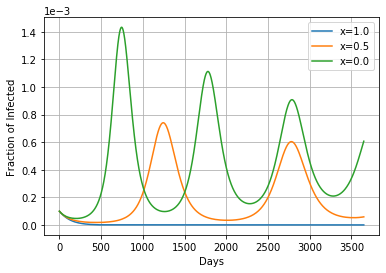

In [3]:
def sirv_simulate(n_days,R0, mu, lmbd, rho, x_func, N0, fI0, fR0):
    
    beta = R0*(mu+lmbd)/(1-rho)
    Z = np.zeros((n_days,3), dtype='int')
    x = np.zeros(n_days)
    x[0] = x_func(0)
    N = np.zeros(n_days)
    N[0] = N0
    Z[0,1] = int(N[0]*fI0)
    Z[0,2] = int(N[0]*fR0)
    Z[0,0] = N[0]-Z[0,1]-Z[0,2]
    D = np.zeros(n_days)
    for t in range(n_days-1):
        FOI  = beta*Z[t,1]/N[t]
        deaths = (Z[t,:]*lmbd).astype('int')
        deaths_I = (deaths[1]/(1-rho)).astype('int')
        D[t] = deaths_I-deaths[1]
        new_vaccinated =(np.sum(deaths)*x[t]).astype('int')
        new_susceptible = np.sum(deaths) - new_vaccinated
        infected = (Z[t,0]*FOI).astype('int')
        recovered = (Z[t,1]*mu/(1-rho)).astype('int')
        Z[t+1,0] = Z[t,0] + new_susceptible - infected - deaths[0]
        Z[t+1,1] = Z[t,1] + infected - recovered - deaths_I
        Z[t+1,2] = Z[t,2] + new_vaccinated + recovered - deaths[2]
        N[t+1] = np.sum(Z[t+1,:])
        x[t+1] = x_func(t+1)
    return Z,N,D,x

np.random.seed(123456789)
n_days = 10*365
rho = 0.002
mu = 1/14
lmbd = 1/(80*365)
R0 = 18
beta = R0*(mu+lmbd)/(1-rho)
N0 = 60000000
fI0= 0.0001
fR0 = 0.95
T=365
x_func = {'one':lambda t: 1.0, 'half' : lambda t: 0.5, 'zero' : lambda t: 0.0, 'exp' : lambda t: 0.7+0.3*np.exp(-t/T), 'osc' : lambda t: 0.5+0.5*np.cos(2*np.pi*t/T)   }
n_samples = 100
compartments = {'S':0, 'I':1, 'R':2}
labels = {'S':'Susceptible', 'I':'Infected','R':'Recovered'}
const_labels = {'one':'x=1.0','half':'x=0.5','zero':'x=0.0'}
#fig, ax = plt.subplots(figsize=(10,8))
fig, ax = plt.subplots()
for mode in ['one','half','zero']:
    Z,N,D,x = sirv_simulate(n_days,R0, mu, lmbd, rho,x_func[mode],N0,fI0,fR0)
    ax.plot(Z[:,compartments['I']]/N, label=const_labels[mode])

plt.xlabel('Days')
plt.ylabel('Fraction of '+ labels['I'])
plt.grid()
plt.legend()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.savefig('mf_const_'+labels['I']+'.png')


plt.show()

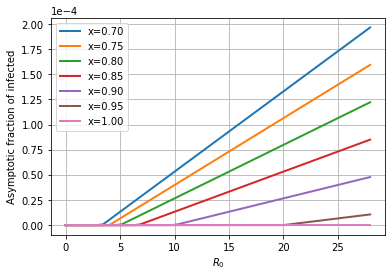

In [4]:
#fig, ax = plt.subplots(figsize=(10,8))
fig, ax = plt.subplots()
betas = np.linspace(0,2)
xs = np.linspace(0.7,1,7)
for vacc in xs:
    curve = (lmbd/beta)*(((1-vacc)*(betas)/(mu+lmbd))-1)
    ax.plot(betas/(mu+lmbd), np.where(curve>0, curve, 0), lw=2, label='x=%1.2f'%vacc)
plt.xlabel(r"$ R_0 $")
plt.ylabel('Asymptotic fraction of infected')
plt.legend()
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.savefig('phdiag.png')
plt.show()

# SIR with vaccination and metapopulation model

In [0]:
pop_url = 'https://www.dropbox.com/s/igo8rtd2hy6471k/pop_prov_2011.csv?dl=1'
mob_url = 'https://www.dropbox.com/s/hjvyb5aly74qol7/mob_prov_2011.csv?dl=1'

In [0]:
pop = pd.read_csv(pop_url, sep=',')
mob = pd.read_csv(mob_url, sep=',')

In [0]:
df = pd.merge(mob,pop,left_on='P',right_on='P')
fraction = df['CNT'].values/df['POP'].values
df.insert(2, 'FRACTION',fraction)
df['P'] = df['P']-1
df['TP'] = df['TP']-1
pop['P'] = pop['P']-1

In [0]:
n_patches = len(pop)
A = np.zeros((n_patches, n_patches))
for i, x in enumerate(df[['P', 'TP']].values):
    cnt = df.iloc[i]['FRACTION']
    if(np.isfinite(cnt)):
        A[x[0], x[1]] = cnt

In [0]:
B = A.copy()
B[B>0]= 1
gph = nx.Graph(B)

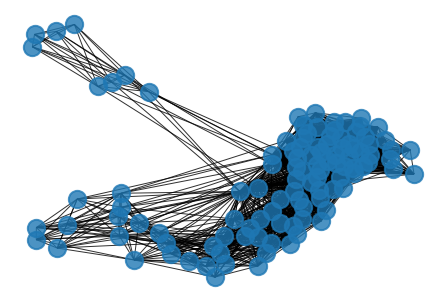

In [0]:
nx.draw(gph, linewidths=2, alpha=0.8)#,style='dotted',alpha=0.8,node_color='r')
ax = plt.gca() # to get the current axis

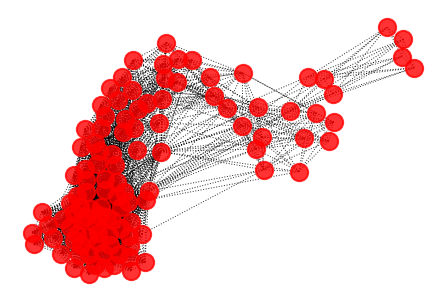

In [0]:
nx.draw(gph, style='dotted',alpha=0.8, linewidths=2.0,node_color='r')

In [0]:
#[:,None] moltiplica la colonna
class CommutingMP:
    def __init__(self, adjMatr, return_rate, initPopulation): #return_rate should be approx (8 h)^-1
        self.n_nodes = adjMatr.shape[0]
        self.adj = adjMatr.copy()
        self.rho = return_rate
        self.sigma_i = np.sum(self.adj, axis=1)
        self.N_ij = np.zeros((self.n_nodes, self.n_nodes), dtype=int)
        self.N_ii =initPopulation.copy().astype('int')

    def get_asymptotics_params(self):
        temp = (self.adj/(self.rho))/(1+self.sigma_i/self.rho)
        return 1.0-np.sum(temp, axis=1), temp

In [0]:
class SocialDynamics:
    def __init__(self, adj, init_op):
        self.n_nodes = len(init_op)
        self.adj = adj.copy()
        # list of nodes connected to node i
        self.adj_list = [np.argwhere(self.adj[:,i]).reshape(-1) for i in range(self.n_nodes)]
        self.x = init_op.copy()
    def step(self,eps,mu,policy=1):
        visited = set()
        # loop over all the nodes
        for i in range(self.n_nodes):
          # if i is not visited I visit it
          if not i in visited:
            visited.add(i)
            # I shuffle the list
            js = np.random.choice(self.adj_list[i], size=len(self.adj_list[i]), replace=False)
            j = None
            # if the element (neighbour of i) is not visited I visit it
            for el in js:
                  if(not el in visited):
                    j=el
                    break
            # if I found j not visited before I do something
            if j:
              dx = np.abs(self.x[i]-self.x[j])
              if(dx > eps):
                  #policy 1: min -> no vax wins
                  #policy 2: max -> vax wins
                  #policy 3: mean -> neutral policy
                    min_val = min(self.x[i],self.x[j])
                    max_val = max(self.x[i],self.x[j])
                    mean_val = (self.x[i]+self.x[j])/2
                    if(policy==2):
                        self.x[i] += mu*(max_val-self.x[i])
                        self.x[j] += mu*(max_val-self.x[j])
                    elif(policy==3):
                        self.x[i] += mu*(mean_val-self.x[i])
                        self.x[j] += mu*(mean_val-self.x[j])
                    else:
                        self.x[i] += mu*(min_val-self.x[i])
                        self.x[j] += mu*(min_val-self.x[j])
                visited.add(j)
        return self.x

In [0]:
class SIR:
       def __init__(self,pop_init, fS0, fI0,fR0, f_ii, f_ij):
        self.n_patches = len(pop_init)
        #population
        self.pop0 = pop_init.copy()
        self.f_ii = f_ii.copy()
        self.f_ij = f_ij.copy()
        #distribute between compartments
        X_i = np.zeros((3,self.n_patches), dtype='int64')
        X_i[0] = (self.pop0*fS0).astype('int64')
        X_i[1] = (self.pop0*fI0).astype('int64')
        X_i[2] = (self.pop0-X_i[0]-X_i[1]).astype('int64')

        self.X_ij = np.array( [self.f_ij*X_i[0][:,None], self.f_ij*X_i[1][:,None], self.f_ij*X_i[2][:,None]]).astype('int64')
        self.X_ii = (X_i - np.sum(self.X_ij, axis=2)).astype('int64')
        self.N_i = (np.sum(self.X_ii, axis=0)+np.sum(self.X_ij, axis=(0,1))).astype('int64')

        self.N_ii = (np.sum(self.X_ii, axis=0)).astype('int64')
        self.N_ij = (np.sum(self.X_ij, axis=0)).astype('int64')

  # Checkpoint
  def step(self, beta, mu, lmbd, rho, x,delta):
    if((self.X_ii[0]<0).any()):
          print('ERROR S')
    if((self.X_ii[1]<0).any()):
          print('ERROR I')
    if((self.X_ii[2]<0).any()):
          print('ERROR R')
    if((x<0).any() or (x>1).any()):
          print('ERROR x')
  
    #Force of Infection:
    self.l_ii = (self.X_ii[1]+np.sum(self.X_ij[1], axis=0))*(beta/self.N_i)
    #self.l_ii = np.where(self.l_ii >= 1, 1.0, self.l_ii)
    self.l_ij =beta*np.repeat((self.X_ii[1].reshape(1,-1)+np.sum(self.X_ij[1], axis=0).reshape(1,-1))/self.N_i.reshape(-1), repeats=self.n_patches,axis=0)
    #self.l_ij = np.where(self.l_ij >= 1, 1.0, self.l_ij)
    # Infected ii: new infected from susceptible
    dI_ii = (delta*self.l_ii*self.X_ii[0]).astype('int')
    #print(dI_ii)
    #print(self.X_ii[0])
    # Infected ij
    dI_ij = (delta*self.l_ij*self.X_ij[0]).astype('int')

    # Recovered ii: new recovered from infected
    dR_ii = (delta*mu*self.X_ii[1]).astype('int')
    # Recovered ij
    dR_ij =  (delta*mu*self.X_ij[1]).astype('int')

    
    # Death ii
    dD_ii=(lmbd*delta*self.X_ii).astype('int')
    # Death ij
    dD_ij=(lmbd*delta*self.X_ij).astype('int')

    # Newborns: they should be the same number as the deaths from aging
    dB_ii = np.sum(dD_ii,axis=0)
    dB_ij = np.sum(dD_ij,axis=0)

    # Vaccination ii
    # fraction of new vaccinated
    dV_ii = (x*dB_ii).astype('int')
    # Vaccination ij
    dV_ij = (x*dB_ij).astype('int')

    dDI_ii = (dD_ii[1]/(1-rho)).astype('int')
    dDI_ij = (dD_ij[1]/(1-rho)).astype('int')
    dR_ii = (dR_ii/(1-rho)).astype('int')
    dR_ij = (dR_ij/(1-rho)).astype('int')

      
    # Update
    self.X_ii[0] += dB_ii - dV_ii - dI_ii - dD_ii[0] 
    self.X_ij[0] += dB_ij - dV_ij - dI_ij - dD_ij[0] 
    self.X_ii[1] += dI_ii - dR_ii - dDI_ii
    self.X_ij[1] += dI_ij - dR_ij - dDI_ij
    self.X_ii[2] += dR_ii + dV_ii - dD_ii[2]
    self.X_ij[2] += dR_ij + dV_ij - dD_ij[2]
    self.N_i = (np.sum(self.X_ii, axis=0)+np.sum(self.X_ij, axis=(0,1))).astype('int64')

  def simulate(self, n_steps,beta,mu,lmbd,rho,x_func,delta, verbosity=5):
    X_tot = np.zeros((n_steps,3))
    for t in range(n_steps):
      X_tot[t,0] = np.sum(self.X_ii[0]+np.sum(self.X_ij[0], axis=1))
      X_tot[t,1] = np.sum(self.X_ii[1]+np.sum(self.X_ij[1], axis=1))
      X_tot[t,2] = np.sum(self.X_ii[2]+np.sum(self.X_ij[2], axis=1))
      new_x = x_func(t)
      self.step(beta, mu,lmbd,rho,new_x,delta)
      if(verbosity > 0 and t % verbosity == 0):
        print('Iteration',t)
    return X_tot


In [0]:
def full_simulation(sim_params,pop_params, sir_params, opi_params, imp_params, ics_params):
  n_patches = len(ics_params['opinion0'])
  time = np.arange(0, sim_params['n_steps'])

  #create the opinion dynamics

  er_gph = nx.erdos_renyi_graph(n_patches, opi_params['p'], seed=None, directed=False)
  net = nx.to_numpy_matrix(er_gph)
  
  #simulate
  op = SocialDynamics(net, ics_params['opinion0'])
  op_hist = np.zeros((sim_params['n_steps'],n_patches))
  impurities_times = []
  for t in time:
    op.x = op.step(opi_params['eps'],opi_params['mu_social'],opi_params['policy'])
    op_hist[t,:] = op.x
    if(np.random.rand()<imp_params['p_impurity']):
      impurity_loc = np.random.choice(n_patches, size=imp_params['n_impurities'], replace=False)
      #print('At time',t,'a random change occurred at:', impurity_loc)
      op.x[impurity_loc]=np.random.rand(imp_params['n_impurities'])*(imp_params['max_imp']-imp_params['min_imp'])+imp_params['min_imp']
      impurities_times.append(t)
  x_func = lambda t: op_hist[t]
  sir = SIR(pop['POP'].values,ics_params['s_frac0'],ics_params['i_frac0'],ics_params['r_frac0'],pop_params['fii'],pop_params['fij'])
  beta = (1-sir_params['rho'])*sir_params['R0']*(sir_params['lmbd']+sir_params['mu'])
  X_total = sir.simulate(n_steps=sim_params['n_steps'],beta=beta,mu=sir_params['mu'],lmbd=sir_params['lmbd'],rho=sir_params['rho'],x_func=x_func,delta=sim_params['delta'],verbosity=0)
  return time, X_total, op_hist, impurities_times

In [0]:
def Result(X_total,op_hist,time):
  print('Final susceptible: ', X_total[-1,0])
  print('Final infected: ',X_total[-1,1])
  print('Final recovered: ',X_total[-1,2])
  print('Final population: ',X_total[-1,0]+X_total[-1,1]+X_total[-1,2])
  print('Dead population: ',(X_total[0,0]+X_total[0,1]+X_total[0,2])-(X_total[-1,0]+X_total[-1,1]+X_total[-1,2]))

  plt.plot(time*0.5,X_total[:,0],label='S')
  plt.grid(which='both')
  plt.yscale('log')
  plt.xlabel('Days')
  plt.ylabel('Susceptibles')
  plt.legend()
  plt.show()

  plt.plot(time*0.5,X_total[:,1],label='I')
  plt.grid(which='both')
  plt.xlabel('Days')
  plt.ylabel('Infected')
  plt.legend()
  plt.show()

  plt.plot(time*0.5,X_total[:,2],label='R')
  plt.grid(which='both')
  plt.yscale('log')
  plt.xlabel('Days')
  plt.ylabel('Recovered')
  plt.legend()
  plt.show()

  plt.plot(time*0.5,np.mean(op_hist,axis=1),label='Opinion')
  plt.grid(which='both')
  plt.xlabel('Days')
  plt.ylabel('Average opinion')
  plt.legend()
  plt.show()

Final susceptible:  7503104.0
Final infected:  1864.0
Final recovered:  51255615.0
Final population:  58760583.0
Dead population:  0.0


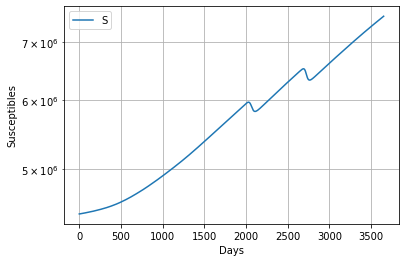

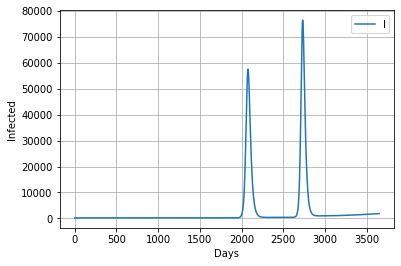

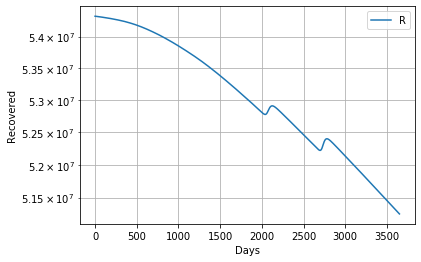

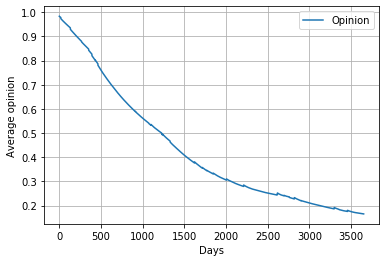

In [15]:
#SIR PARAMETERS: R0, mu, lmbd, rho, x_func
#METAPOP PARAMETERS: f_ii, f_ij
#OPINION PARAMETERS: eps, mu_social, policy
#IMPURITY PARAMETERS: p_impurity, n_impurities, min_imp=0.0, max_imp=1.0
#INITIAL CONDITIONS: s_frac0, i_frac0, r_frac0, opinion0  
#SIMULATION PARAMETERS: delta, n_steps


#-----------------------HYPERPARAMETERS-----------------------
#METAPOPULATION ASYMPTOTIC STATE:
mpop = CommutingMP(A, 3, pop['POP']) #3 is 1/(8 hours in days)=1/(1/3 day)=3
f_ii, f_ij = mpop.get_asymptotics_params()
n_patches = len(pop['POP'])
#SIMULATION PARAMETERS
delta = 0.5
n_days = 10*365
#INITIAL CONDITIONS
np.random.seed(1234) #used to fix the simulation being stochastic in the opinion dynamics

n_infected_patches = 110
ill_indices = np.random.choice(len(pop['POP']), n_infected_patches)
i_frac0 = np.zeros(len(pop['POP']))
i_frac0[ill_indices] = np.random.rand(len(ill_indices))*0.00001 
r_frac0 = np.random.rand(len(pop['POP']))*(0.05)+0.9
s_frac0 = 1 - i_frac0 - r_frac0

init_op = np.ones(n_patches)
n_antivax = 10
init_op[np.random.choice(n_patches, n_antivax,replace=False)]=np.random.rand(n_antivax)*0.2+0.7

#-----------------------MODEL SPECIFICATION-----------------------
sim_params = {'delta' : delta, 'n_steps' : int(n_days/delta)}
pop_params = {'fii':f_ii, 'fij':f_ij}
sir_params = {'R0':18, 'mu':1/14, 'lmbd' : 1/(80*365), 'rho' : 0.002}
opi_params = {'eps' : 0.1, 'mu_social' : 0.02*delta, 'policy' : 1, 'p' : 1.0}
imp_params = {'p_impurity' : 0.005, 'n_impurities' : 1, 'min_imp' : 0, 'max_imp' : 1.0}
ics_params = {'s_frac0' : s_frac0, 'i_frac0' : i_frac0, 'r_frac0' : r_frac0, 'opinion0' : init_op  }

time, X_total1, op_hist1, impurities_times = full_simulation(sim_params, pop_params,sir_params, opi_params, imp_params, ics_params)

Result(X_total1, op_hist1, time)

NameError: ignored

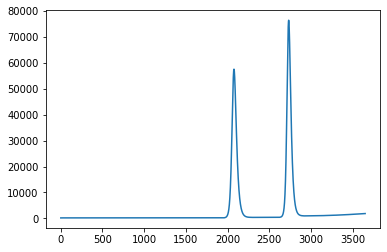

In [16]:
plt.plot(time*delta,X_total1[:,1],label='Policy 1')
plt.plot(time*delta,X_total2[:,1],label='Policy 2')
plt.plot(time*delta,X_total3[:,1],label='Policy 3')
plt.grid(which='both')
plt.xlabel('Days')
plt.ylabel('Infected')
plt.legend()
plt.savefig('1In.png')
plt.show()

plt.plot(time*delta,np.mean(op_hist1,axis=1),label='Policy 1')
plt.plot(time*delta,np.mean(op_hist2,axis=1),label='Policy 2')
plt.plot(time*delta,np.mean(op_hist3,axis=1),label='Policy 3')
plt.grid(which='both')
plt.xlabel('Days')
plt.ylabel('Average opinion')
plt.legend()
plt.savefig('1Op.png')
plt.show()

### Target initialization

In [0]:
def pocket_full_simulation(sim_params,pop_params, sir_params, opi_params, imp_params, ics_params):
  n_patches = 110
  time = np.arange(0, sim_params['n_steps'])

  #create the opinion dynamics
  #erdos-renyi
  er_gph = nx.erdos_renyi_graph(n_patches, opi_params['p'], seed=None, directed=False)
  net = nx.to_numpy_matrix(er_gph)
  degree = np.array([d for n,d in er_gph.degree()])
  
  #no vax on the minima
  if opi_params['kind']==1:
      #init opinion
      init_op = np.ones(n_patches)
      index = np.argsort(degree)
      index=index[:ics_params['no_vax0']]
      init_op[index]=np.random.rand(ics_params['no_vax0'])*0.2+0.5
  #no vax on the maxima
  else:
      #init opinion
      init_op = np.ones(n_patches)
      index = np.argsort(degree)
      index = index[::-1]
      index = index[:ics_params['no_vax0']]
      init_op[index]=np.random.rand(ics_params['no_vax0'])*0.2+0.5

  #simulate
  op = SocialDynamics(net, init_op)
  op_hist = np.zeros((sim_params['n_steps'],n_patches))
  impurities_times = []
  for t in time:
    op.x = op.step(opi_params['eps'],opi_params['mu_social'],opi_params['policy'])
    op_hist[t,:] = op.x
    if(np.random.rand()<imp_params['p_impurity']):
      impurity_loc = np.random.choice(n_patches, size=imp_params['n_impurities'], replace=False)
      #print('At time',t,'a random change occurred at:', impurity_loc)
      op.x[impurity_loc]=np.random.rand(imp_params['n_impurities'])*(imp_params['max_imp']-imp_params['min_imp'])+imp_params['min_imp']
      impurities_times.append(t)
  x_func = lambda t: op_hist[t]
  sir = SIR(pop['POP'].values,ics_params['s_frac0'],ics_params['i_frac0'],ics_params['r_frac0'],pop_params['fii'],pop_params['fij'])
  beta = (1-sir_params['rho'])*sir_params['R0']*(sir_params['lmbd']+sir_params['mu'])
  X_total = sir.simulate(n_steps=sim_params['n_steps'],beta=beta,mu=sir_params['mu'],lmbd=sir_params['lmbd'],rho=sir_params['rho'],x_func=x_func,delta=sim_params['delta'],verbosity=0)
  return time, X_total, op_hist, impurities_times

Final susceptible:  5028209.0
Final infected:  196.0
Final recovered:  53732178.0
Final population:  58760583.0
Dead population:  0.0


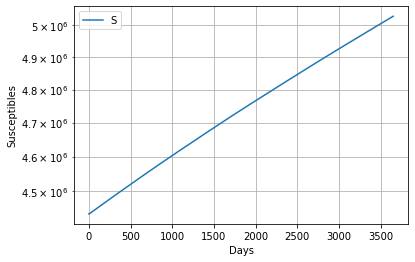

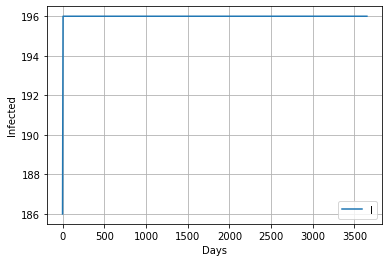

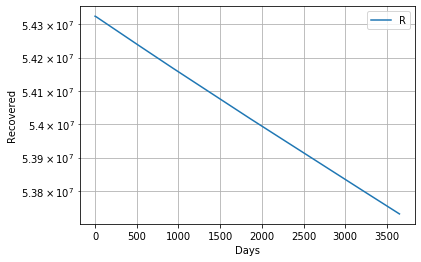

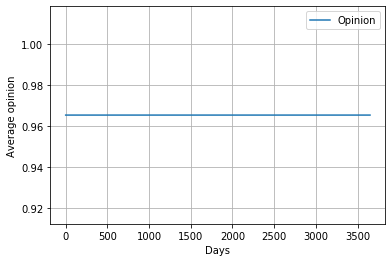

In [30]:
#SIR PARAMETERS: R0, mu, lmbd, rho, x_func
#METAPOP PARAMETERS: f_ii, f_ij
#OPINION PARAMETERS: eps, mu_social, policy
#IMPURITY PARAMETERS: p_impurity, n_impurities, min_imp=0.0, max_imp=1.0
#INITIAL CONDITIONS: s_frac0, i_frac0, r_frac0, opinion0  
#SIMULATION PARAMETERS: delta, n_steps


#-----------------------HYPERPARAMETERS-----------------------
#METAPOPULATION ASYMPTOTIC STATE:
mpop = CommutingMP(A, 3, pop['POP']) #3 is 1/(8 hours in days)=1/(1/3 day)=3
f_ii, f_ij = mpop.get_asymptotics_params()
n_patches = len(pop['POP'])
#SIMULATION PARAMETERS
delta = 0.5
n_days = 10*365
#INITIAL CONDITIONS
np.random.seed(1234) #used to fix the simulation being stochastic in the opinion dynamics

n_infected_patches = 110
ill_indices = np.random.choice(len(pop['POP']), n_infected_patches)
i_frac0 = np.zeros(len(pop['POP']))
i_frac0[ill_indices] = np.random.rand(len(ill_indices))*0.00001 
r_frac0 = np.random.rand(len(pop['POP']))*(0.05)+0.9
s_frac0 = 1 - i_frac0 - r_frac0

no_vax0 = 10

#-----------------------MODEL SPECIFICATION-----------------------
sim_params = {'delta' : delta, 'n_steps' : int(n_days/delta)}
pop_params = {'fii':f_ii, 'fij':f_ij}
sir_params = {'R0':18, 'mu':1/14, 'lmbd' : 1/(80*365), 'rho' : 0.002}
opi_params = {'eps' : 0.1, 'mu_social' : 0.02*delta, 'policy' : 3, 'p' : 0.7, 'kind': 2}
imp_params = {'p_impurity' : 0.005, 'n_impurities' : 0, 'min_imp' : 0, 'max_imp' : 1.0}
ics_params = {'s_frac0' : s_frac0, 'i_frac0' : i_frac0, 'r_frac0' : r_frac0, 'no_vax0': no_vax0}

time, X_total2, op_hist2, impurities_times = pocket_full_simulation(sim_params, pop_params,sir_params, opi_params, imp_params, ics_params)

Result(X_total1, op_hist1, time)

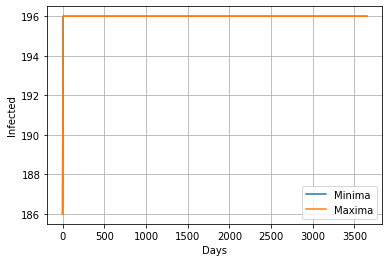

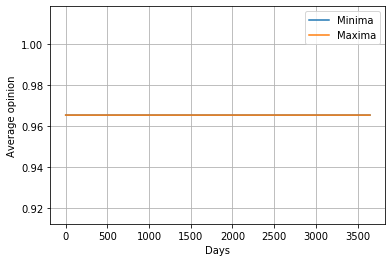

In [31]:
plt.plot(time*0.5,X_total1[:,1],label='Minima')
plt.plot(time*0.5,X_total2[:,1],label='Maxima')
plt.grid(which='both')
plt.xlabel('Days')
plt.ylabel('Infected')
plt.legend()
plt.savefig('8In.png')
plt.show()

plt.plot(time*0.5,np.mean(op_hist1,axis=1),label='Minima')
plt.plot(time*0.5,np.mean(op_hist2,axis=1),label='Maxima')
plt.grid(which='both')
plt.xlabel('Days')
plt.ylabel('Average opinion')
plt.legend()
plt.savefig('8Op.png')
plt.show()

In [0]:
# info of the graph
er_gph = nx.erdos_renyi_graph(n_patches, opi_params['p'], seed=None, directed=False)
degree = np.array([d for n,d in er_gph.degree()])
print('Minimum degree:', np.min(degree))
print('Maximum degree:', np.max(degree))
print('Mean degree:', np.mean(degree))
print('Variance of the degree:', np.mean(degree**2))